<center><h1>Generar Modelo para Competencia Kaggle de Deep Learning</h1></center>

# Cargar librerias

In [1]:
# Cargar librerias
import numpy as np
import random
import os

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from keras.metrics import AUC
from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW 

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing  import RobustScaler, PowerTransformer
from sklearn.pipeline       import Pipeline
from sklearn.compose        import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

from itertools import product

pd.options.display.max_columns = 90

2025-04-28 08:33:37.853072: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 08:33:37.860481: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 08:33:37.911913: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 08:33:37.957068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745847217.996219   39393 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745847218.00

# Cargar Datos

In [2]:
# Cargar Datos de entrenamiento
df_train = pd.read_csv('train_data.csv')

# vista previa
display(df_train.head(5))

,ID,Bankruptcy,Realized.Sales.Gross.Profit.Growth.Rate,Operating.Expense.Rate,Operating.Profit.Per.Share..Yuan...,Gross.Profit.to.Sales,Tax.rate..A.,Current.Liability.to.Liability,Continuous.Net.Profit.Growth.Rate,Long.term.Liability.to.Current.Assets,Total.assets.to.GNP.price,Current.Liabilities.Equity,CFO.to.Assets,Current.Liability.to.Current.Assets,Persistent.EPS.in.the.Last.Four.Seasons,Cash.Total.Assets,Inventory.Working.Capital,Net.Value.Per.Share..B.,Current.Assets.Total.Assets,Net.Worth.Turnover.Rate..times.,Interest.Coverage.Ratio..Interest.expense.to.EBIT.,Equity.to.Liability,Operating.profit.Paid.in.capital,No.credit.Interval,Interest.bearing.debt.interest.rate,Net.Income.to.Stockholder.s.Equity,Quick.Ratio,Cash.Flow.to.Sales,Equity.to.Long.term.Liability,Working.Capital.Equity,After.tax.net.Interest.Rate,Current.Liability.to.Assets,Net.Value.Per.Share..C.,Revenue.per.person,Borrowing.dependency,Operating.Profit.Rate,Long.term.fund.suitability.ratio..A.,Pre.tax.net.Interest.Rate,After.tax.Net.Profit.Growth.Rate,Operating.profit.per.person,Realized.Sales.Gross.Margin,Cash.Current.Liability,Current.Liability.to.Equity,Total.expense.Assets,Current.Asset.Turnover.Rate,Fixed.Assets.Turnover.Frequency,ROA.B..before.interest.and.depreciation.after.tax,Quick.Asset.Turnover.Rate,Debt.ratio..,Retained.Earnings.to.Total.Assets,Total.debt.Total.net.worth,Fixed.Assets.to.Assets,Total.Asset.Growth.Rate,Inventory.and.accounts.receivable.Net.value,Net.Income.Flag,Per.Share.Net.profit.before.tax..Yuan...,Continuous.interest.rate..after.tax.,Liability.Assets.Flag,Working.Capital.to.Total.Assets,Degree.of.Financial.Leverage..DFL.,Operating.Gross.Margin,Contingent.liabilities.Net.worth,Operating.Profit.Growth.Rate,Cash.Flow.to.Liability,Quick.Assets.Total.Assets
0,1,0,0.087661,1.900349e-04,0.131094,0.583345,0.000000,0.815892,0.395719,0.089276,0.000489,0.281141,0.665066,0.066387,0.249061,0.140873,0.431139,0.191173,0.297644,0.024285,0.725172,0.049712,0.078449,0.740116,4.721018e-04,0.860095,0.002406,0.791956,0.217159,0.828121,0.898076,0.059736,0.124798,0.026398,0.437043,0.999062,0.012959,0.861571,0.711694,0.379531,0.620656,0.060332,0.359905,0.009406,4.288144e-03,2.237306e+09,0.586047,5.901952e-05,0.258266,0.942833,0.038263,0.833613,7.620685e+10,0.349014,1,0.223720,0.801737,0,0.839112,0.036551,0.591350,0.007401,0.913175,0.489822,0.138714
1,2,0,0.021892,5.371576e-04,0.086167,0.695478,0.209649,0.768636,0.163505,0.000000,0.018823,0.304522,0.602284,0.038972,0.262613,0.137160,0.322354,0.391213,0.792984,0.067274,0.567918,0.139836,0.343944,0.623515,3.115766e+07,0.819082,0.058836,0.769482,0.211842,0.698552,0.860089,0.139002,0.173522,0.020867,0.502984,0.999227,0.006648,0.819186,0.808840,0.609301,0.694097,0.020014,0.427782,0.142211,1.927473e-04,2.537529e-03,0.561915,1.385376e-03,0.141277,0.962914,0.000594,0.173683,1.003696e+06,0.377744,1,0.324763,0.791203,0,0.908450,0.126752,0.766066,0.020514,0.849241,0.550247,0.704211
2,3,0,0.102249,2.178329e-04,0.157755,0.766934,0.272061,0.643316,0.181571,0.010180,0.020323,0.398060,0.571545,0.102786,0.264661,0.166239,0.416704,0.170455,0.494234,0.015204,0.607235,0.038620,0.100376,0.754268,2.301743e-04,0.870927,0.103190,0.721866,0.217448,0.709177,0.820039,0.165287,0.267027,0.031782,0.556357,0.999100,0.002282,0.857014,0.662214,0.501465,0.566415,0.035103,0.322577,0.016698,5.061000e-03,5.296747e-04,0.609651,9.989531e-03,0.144202,0.957835,0.002228,0.170233,2.675561e+05,0.463732,1,0.360892,0.803126,0,0.865943,0.018152,0.687211,0.004363,0.865814,0.447168,0.398086
3,4,0,0.029972,4.915756e+10,0.249279,0.611580,0.288357,0.752782,0.409196,0.018603,0.051621,0.569484,0.597299,0.020687,0.323814,0.106693,0.316508,0.283815,0.568482,0.055694,0.554564,0.041208,0.301615,0.647968,2.560633e-04,0.895735,0.009577,0.709324,0.099247,0.834494,0.861415,0.234282,0.458725,0.021961,0.321767,0.999235,0.013867,0.816414,0.736790,0.546017,0.630496,0.003352,0.353371,0.106083,1.361321e+09,3.982768e-04,0.689417,4.283614e+09,0.151899,0.939676,0.048031

## Separar variable objetivo  y predictoras

In [3]:
# Se parar variable predictoras
x = df_train.drop(columns='Bankruptcy')

# Se parar variable objetivo 
y = df_train['Bankruptcy']

# Análisis preliminar de variables

In [4]:
# Tamaño del data set x
print("Tamaño del data set: \n", x.shape, "\n")

# Tipos de datos en el data set x
print("Tipos de datos: \n", x.dtypes.value_counts())

Tamaño del data set: 
 (2050, 64) 

Tipos de datos: 
 float64    61
int64       3
Name: count, dtype: int64


In [5]:
# Tamaño del data set y
print("Tamaño del data set: \n", y.shape, "\n")

# Tipo de dato y, distribucion de clases
print("Tipo de dato y distribucion de clases: \n", y.value_counts())

Tamaño del data set: 
 (2050,) 

Tipo de dato y distribucion de clases: 
 Bankruptcy
0    1988
1      62
Name: count, dtype: int64


In [6]:
# Contar Na x
display(x.isna().sum().sum())

# Contar Na y
display(y.isna().sum())

0

0

In [7]:
# Datos estadisticos descriptivos de x
x.describe().round(2)

,ID,Realized.Sales.Gross.Profit.Growth.Rate,Operating.Expense.Rate,Operating.Profit.Per.Share..Yuan...,Gross.Profit.to.Sales,Tax.rate..A.,Current.Liability.to.Liability,Continuous.Net.Profit.Growth.Rate,Long.term.Liability.to.Current.Assets,Total.assets.to.GNP.price,Current.Liabilities.Equity,CFO.to.Assets,Current.Liability.to.Current.Assets,Persistent.EPS.in.the.Last.Four.Seasons,Cash.Total.Assets,Inventory.Working.Capital,Net.Value.Per.Share..B.,Current.Assets.Total.Assets,Net.Worth.Turnover.Rate..times.,Interest.Coverage.Ratio..Interest.expense.to.EBIT.,Equity.to.Liability,Operating.profit.Paid.in.capital,No.credit.Interval,Interest.bearing.debt.interest.rate,Net.Income.to.Stockholder.s.Equity,Quick.Ratio,Cash.Flow.to.Sales,Equity.to.Long.term.Liability,Working.Capital.Equity,After.tax.net.Interest.Rate,Current.Liability.to.Assets,Net.Value.Per.Share..C.,Revenue.per.person,Borrowing.dependency,Operating.Profit.Rate,Long.term.fund.suitability.ratio..A.,Pre.tax.net.Interest.Rate,After.tax.Net.Profit.Growth.Rate,Operating.profit.per.person,Realized.Sales.Gross.Margin,Cash.Current.Liability,Current.Liability.to.Equity,Total.expense.Assets,Current.Asset.Turnover.Rate,Fixed.Assets.Turnover.Frequency,ROA.B..before.interest.and.depreciation.after.tax,Quick.Asset.Turnover.Rate,Debt.ratio..,Retained.Earnings.to.Total.Assets,Total.debt.Total.net.worth,Fixed.Assets.to.Assets,Total.Asset.Growth.Rate,Inventory.and.accounts.receivable.Net.value,Net.Income.Flag,Per.Share.Net.profit.before.tax..Yuan...,Continuous.interest.rate..after.tax.,Liability.Assets.Flag,Working.Capital.to.Total.Assets,Degree.of.Financial.Leverage..DFL.,Operating.Gross.Margin,Contingent.liabilities.Net.worth,Operating.Profit.Growth.Rate,Cash.Flow.to.Liability,Quick.Assets.Total.Assets
count,2050.00,2050.00,2.050000e+03,2050.00,2050.00,2050.00,2050.00,2050.00,2.050000e+03,2.050000e+03,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2.050000e+03,2050.00,2.050000e+03,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2.050000e+03,2050.00,2050.00,2.050000e+03,2.050000e+03,2050.00,2.050000e+03,2050.00,2050.00,2.050000e+03,2050.00,2.050000e+03,2050.00,2050.0,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00,2050.00
mean,1276.68,0.05,1.143592e+10,0.17,0.66,0.15,0.79,0.29,9.294008e+07,1.131508e+06,0.40,0.64,0.06,0.30,0.17,0.35,0.26,0.57,0.08,0.62,0.09,0.17,0.68,5.888515e+07,0.86,4.005590e+08,0.72,0.18,0.77,0.84,0.15,0.26,4319.06,0.45,1.00,0.02,0.83,0.73,0.47,0.66,3.175659e+07,0.40,0.06,5.272116e+09,4.907951e+09,0.61,9.853138e+09,0.17,0.94,1.063234e+06,0.31,2.488923e+10,0.47,1.0,0.25,0.81,0.00,0.84,0.06,0.66,0.02,0.87,0.53,0.46
std,733.77,0.04,6.637064e+10,0.07,0.07,0.17,0.19,0.09,1.985623e+09,3.534875e+07,0.09,0.08,0.05,0.09,0.16,0.09,0.09,0.22,0.06,0.07,0.08,0.08,0.06,1.366092e+09,0.04,1.807937e+10,0.06,0.08,0.05,0.03,0.09,0.09,195550.62,0.09,0.00,0.04,0.04,0.05,0.09,0.07,7.739081e+08,0.09,0.06,4.620072e+10,4.095018e+10,0.09,5.964096e+10,0.09,0.02,3.442681e+07,0.22,8.869889e+10,0.08,0.0,0.09,0.04,0.02,0.06,0.05,0.06,0.02,0.03,0.08,0.21
min,1.00,0.01,0.000000e+00,0.03,0.49,0.00,0.02,0.13,0.000000e+00,0.000000e+00,0.24,0.21,0.00,0.08,0.00,0.21,0.09,0.00,0.00,0.00,0.01,0.02,0.56,0.000000e+00,0.00,0.000000e+00,0.62,0.04,0.51,0.75,0.00,0.10,0.00,0.30,0.98,0.00,0.75,0.51,0.29,0.42,0.000000e+00,0.26,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.00,0.66,0.000000e+00,0.00,0.000000e+00,0.33,1.0,0.01,0.73,0.00,0.63,0.00,0.45,0.00,0.81,0.08,0.00
25%,645.25,0.02,0.000000e+00,0.11,0.61,0.00,0.68,0.22,0.000000e+00,0.000000e+00,0.33,0.59,0.02,0.23,0.06,0.28,0.19,0.41,0.03,0.57,0.04,0.11,0.63,0.000000e+00,0.84,1.000000e-02,0.67,0.12,0.74,0.81,0.08,0.19,0.02,0.38,1.00,0.01,0.80,0.69,0.40,0.61,0.000000e+00,0.34,0.02,0.000000e+00,0.000000e+00,0.55,0.000000e+00,0.10,0.94,1.000000e-02,0.13,7.606215e+05,0.41,1.0,0.18,0.78,0.00,0.80,0.03,0.61,0.01,0.85,0.46

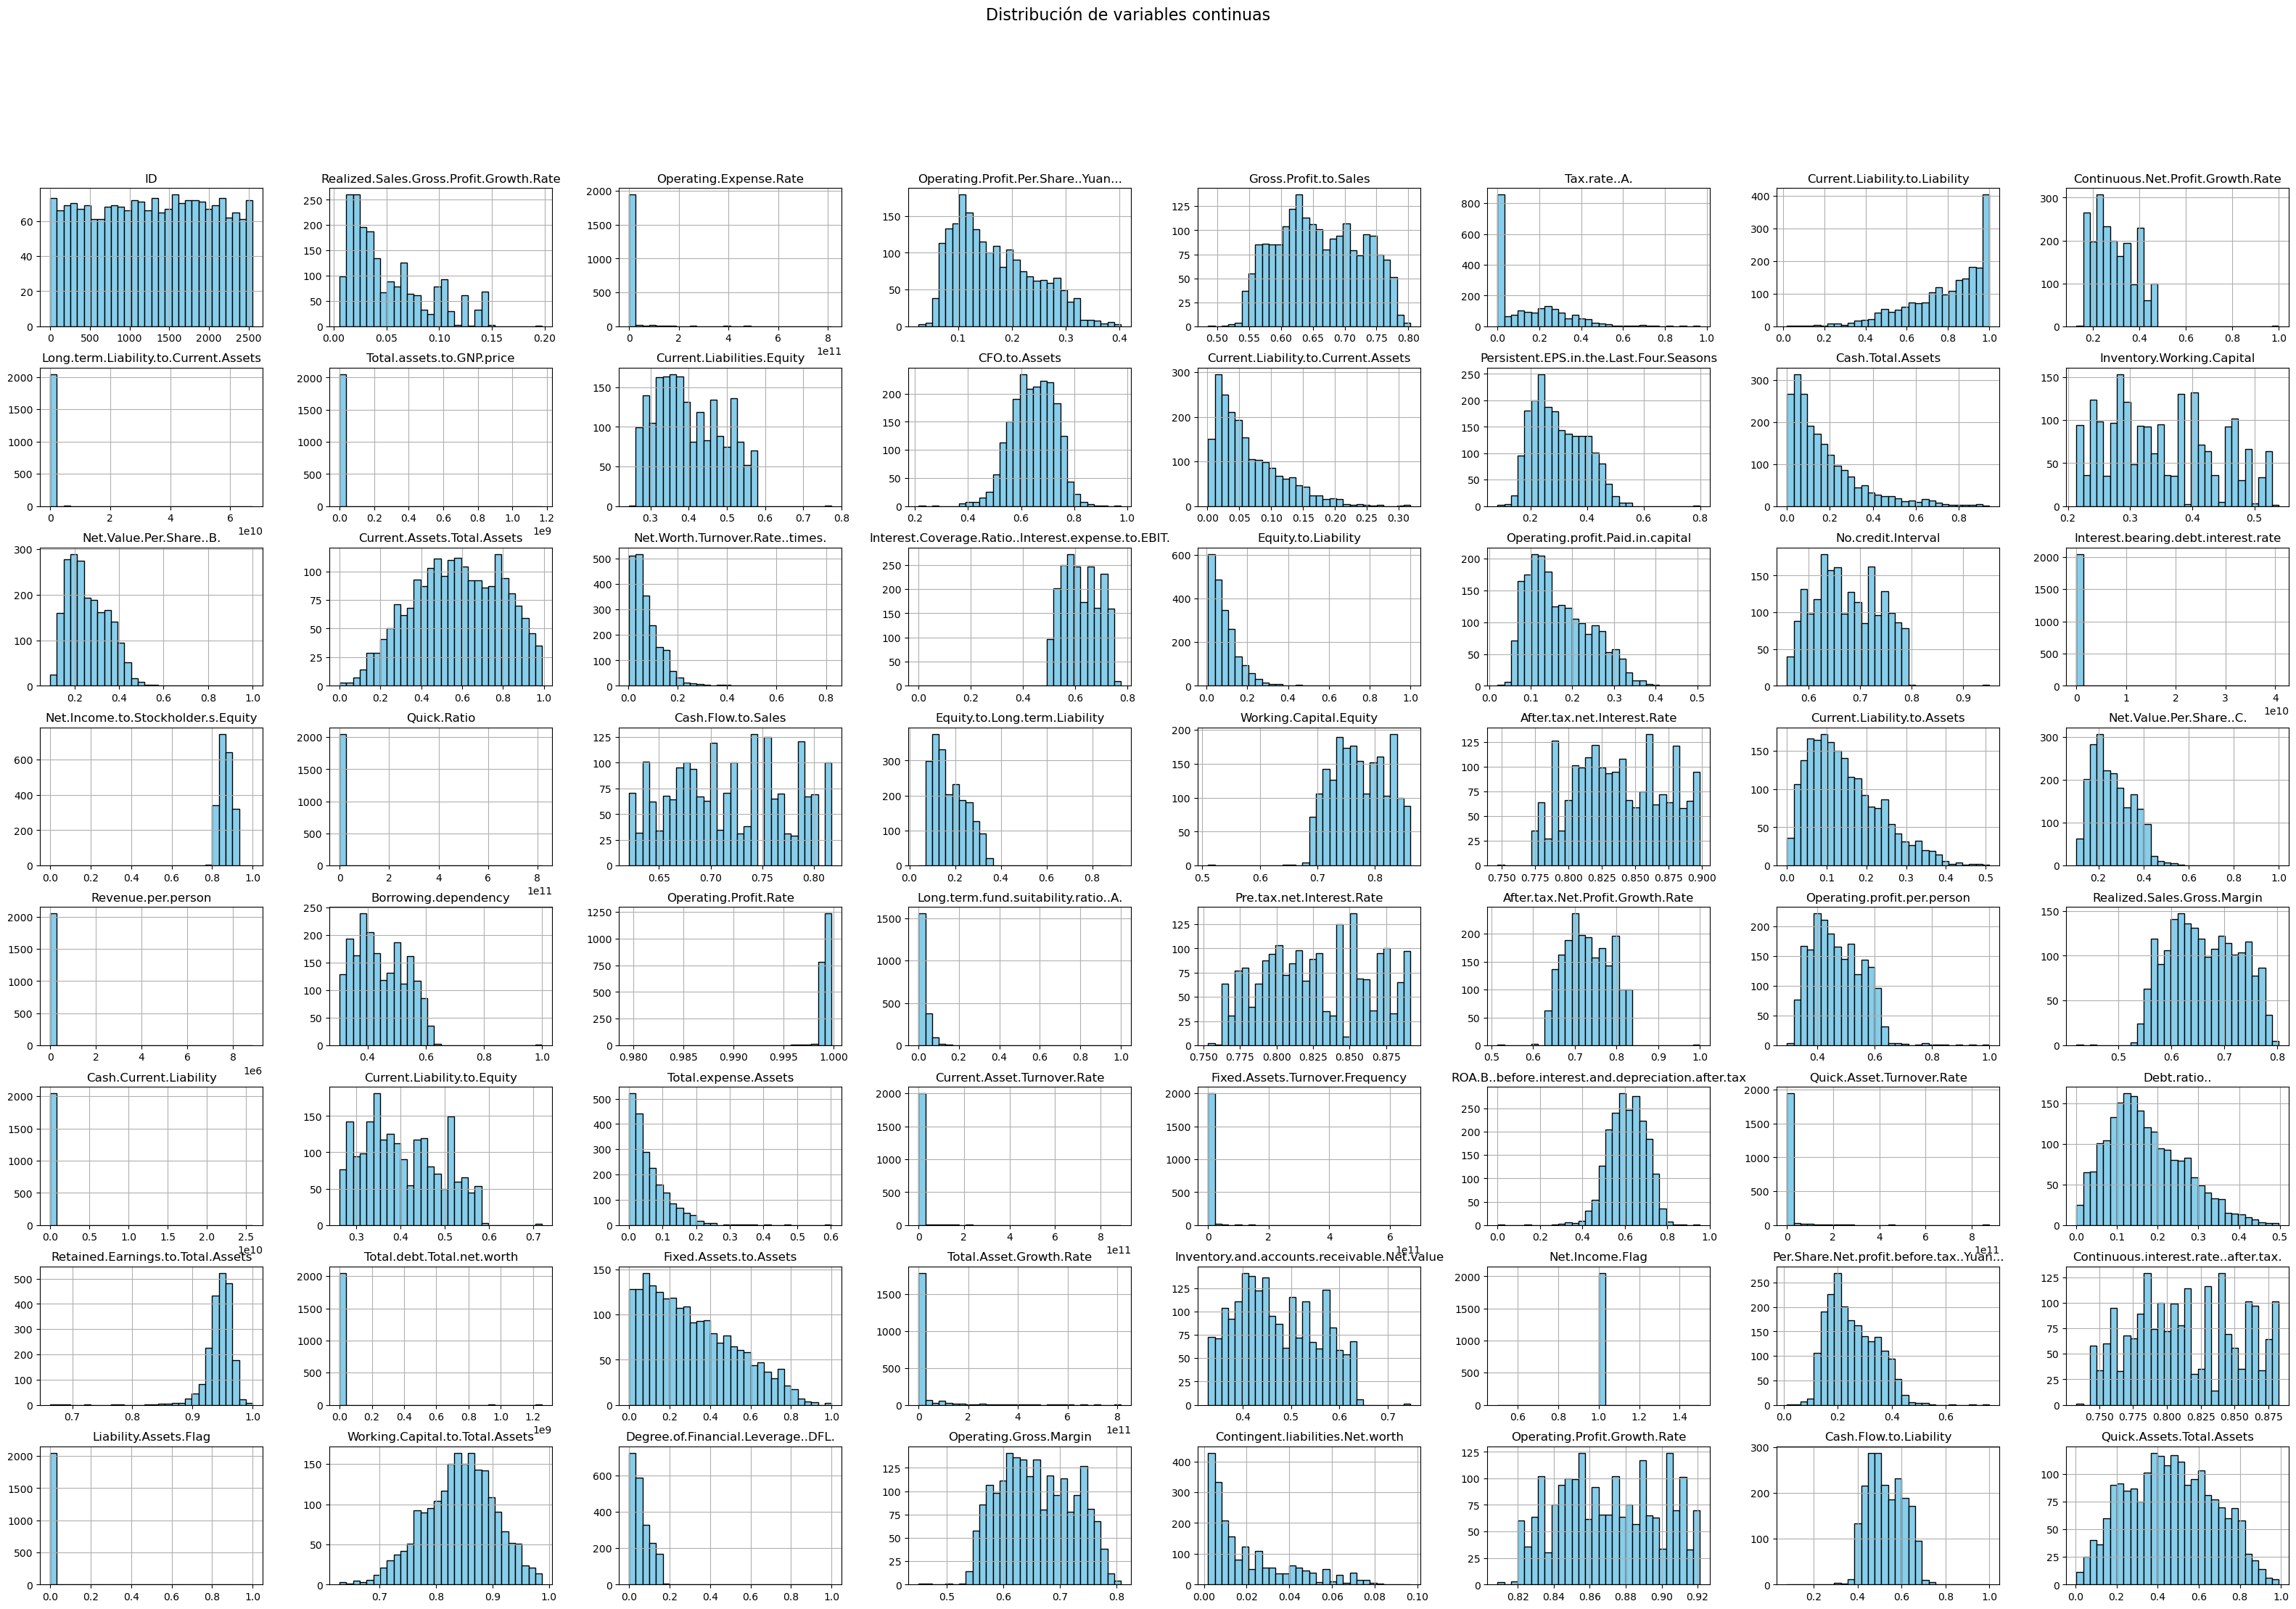

In [8]:
# Histogramas de las variables continuas
x.hist(bins=30, figsize=(40, 25), color='skyblue', edgecolor='black')
plt.suptitle("Distribución de variables continuas", fontsize=16)
plt.show()

C:\Users\danie\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


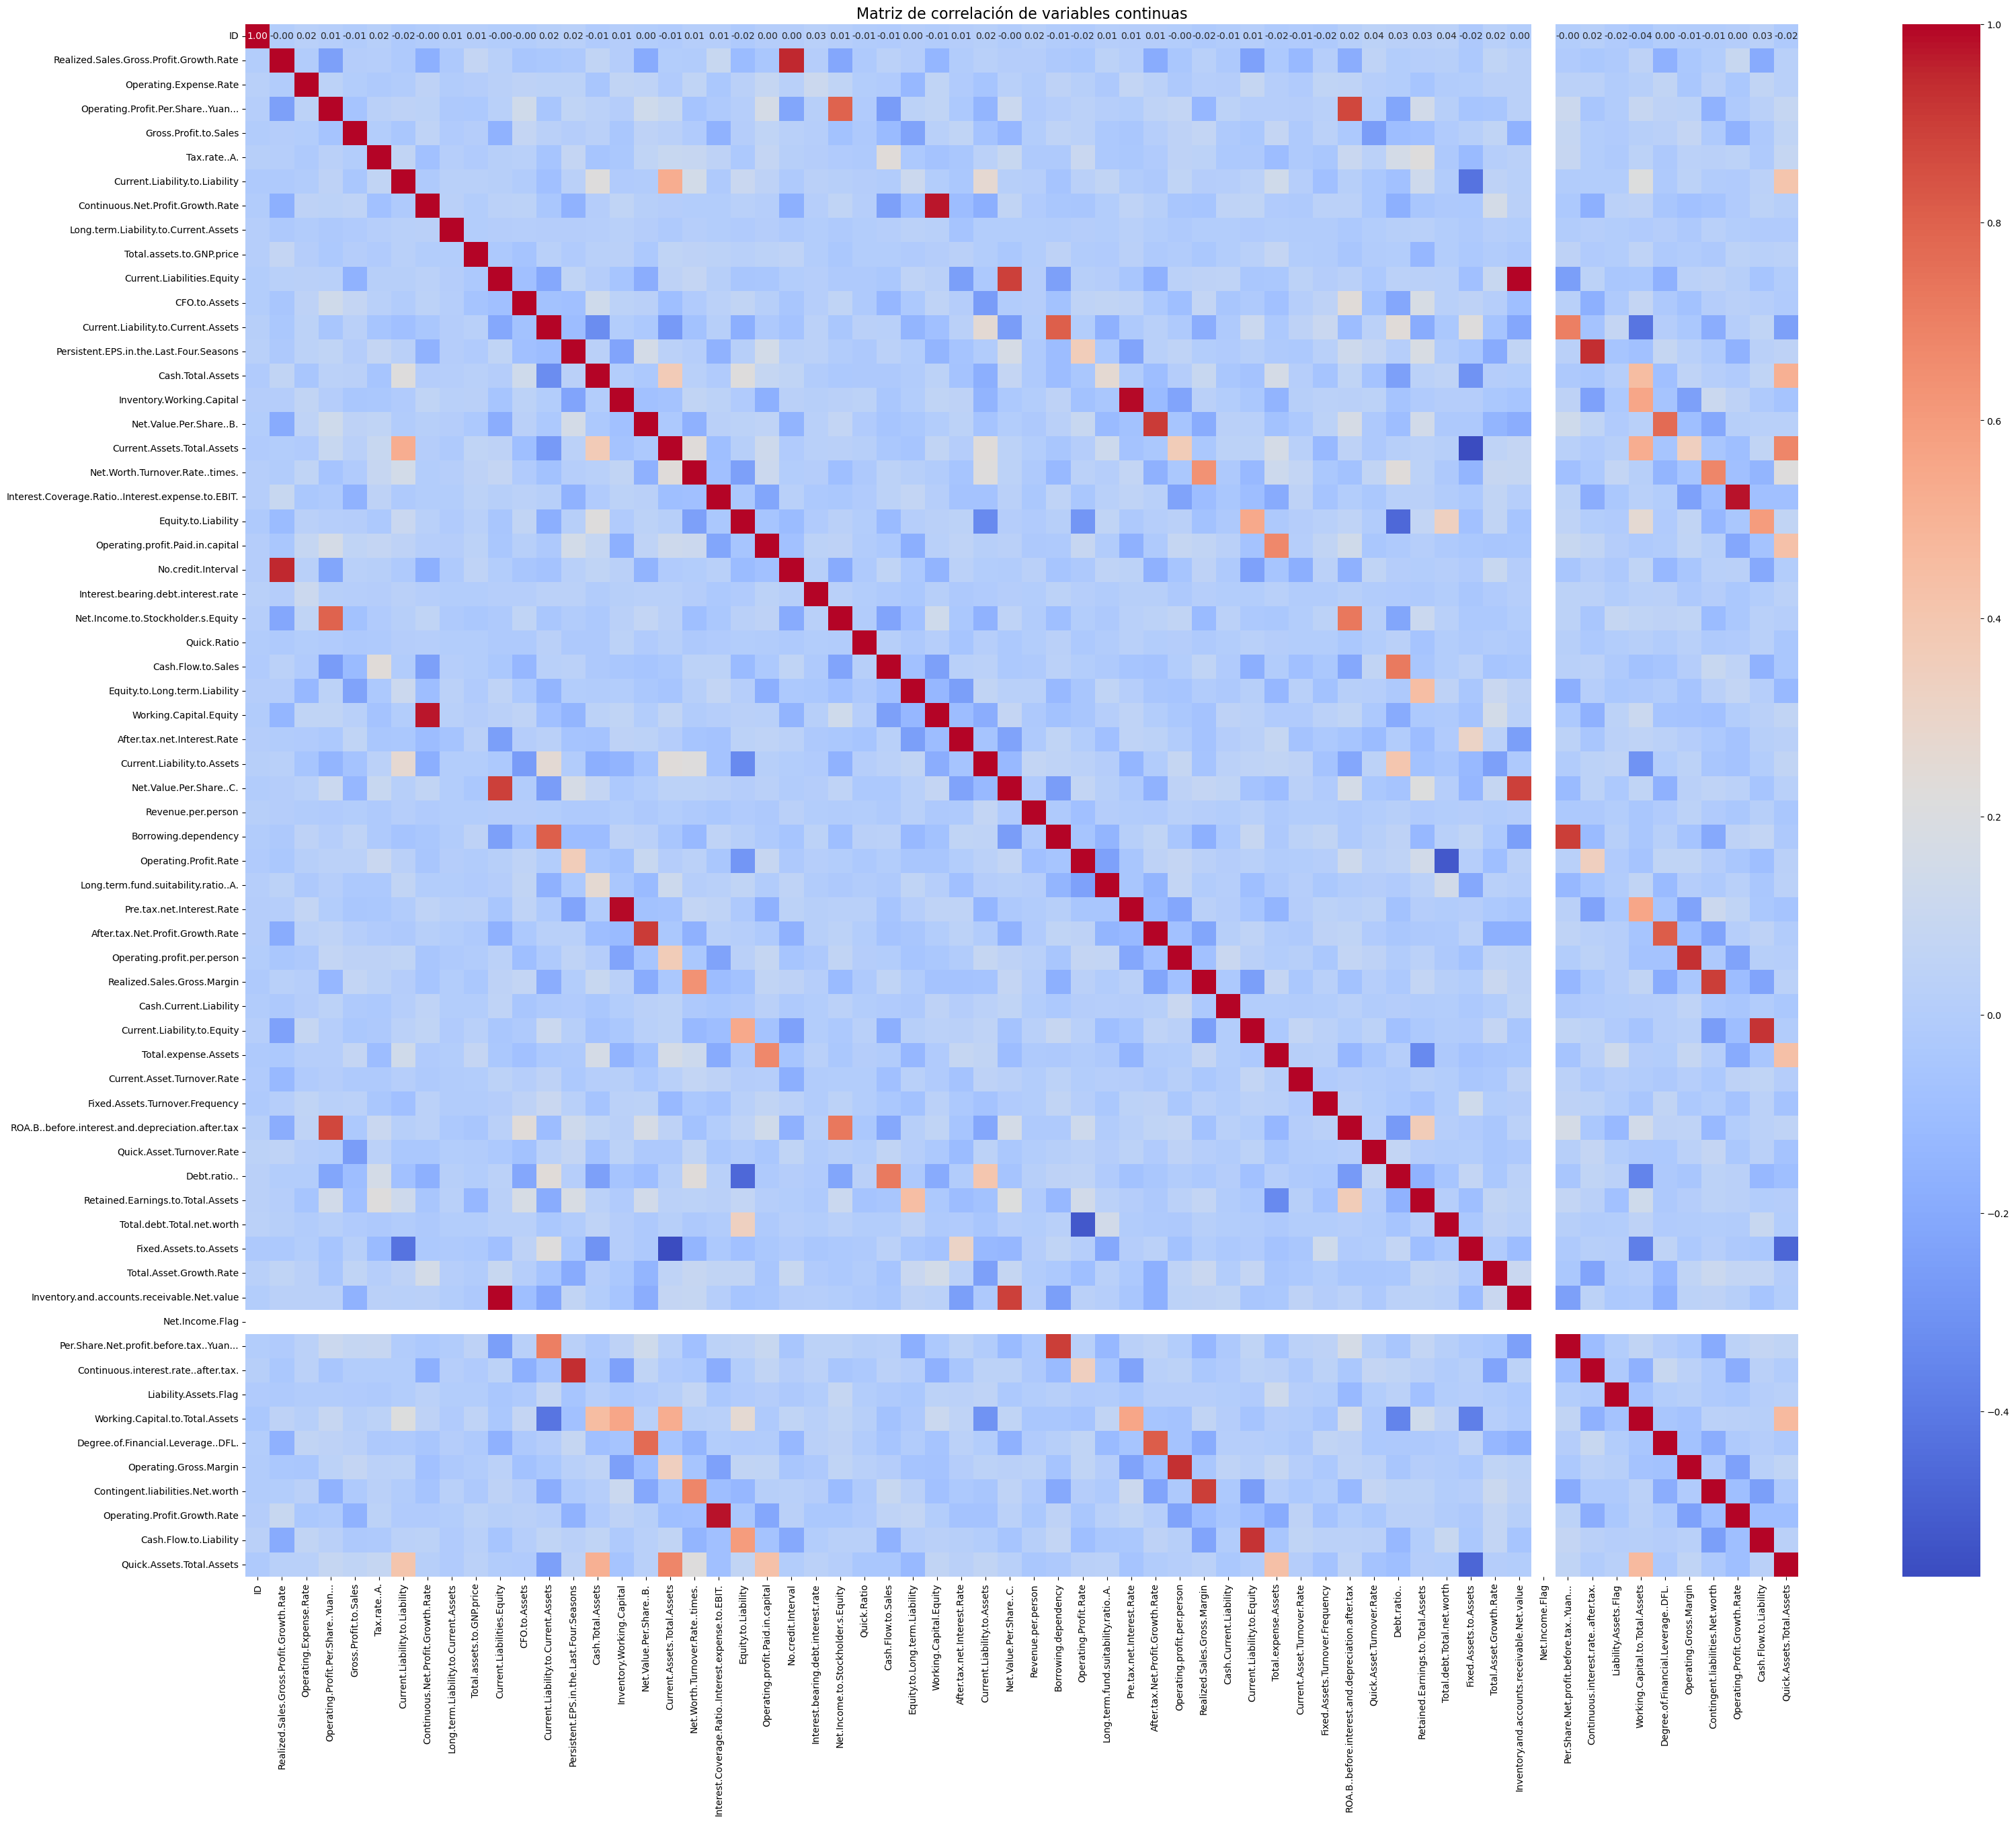

In [9]:
# Correlograma (matriz de correlación)
plt.figure(figsize=(40, 30))
correlation_matrix = x.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlación de variables continuas", fontsize=16)
plt.show()

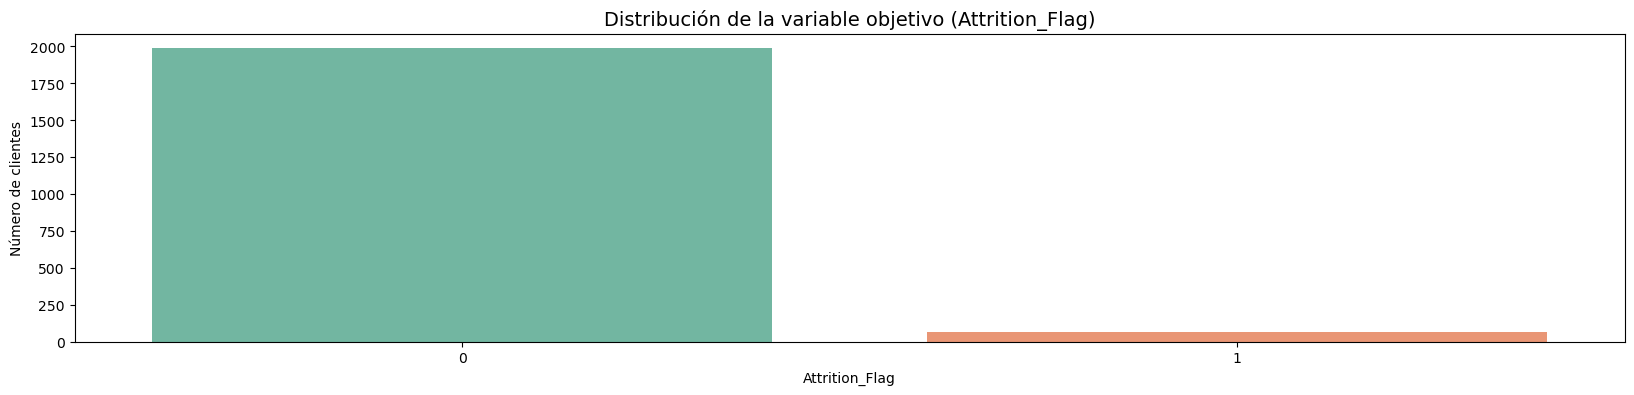

In [10]:
# Distribución de la variable objetivo
plt.figure(figsize=(20, 4))
sns.countplot(x=y, palette="Set2")
plt.title("Distribución de la variable objetivo (Attrition_Flag)", fontsize=14)
plt.xlabel("Attrition_Flag")
plt.ylabel("Número de clientes")
plt.xticks(rotation=0)
plt.show()

# Estimación del modelo usando una red neuronal con keras

## Modelo 1

### Seleccion de variables

In [ ]:
var_eliminar = ["ID"]

In [ ]:
x_filtro = x.drop(columns=var_eliminar)
print(f"Columnas de entrada {x_filtro.shape[1]}")

### Estandarizacion de dataset y conjuntos entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_filtro, y, stratify=y, test_size=0.1, random_state=42)

In [ ]:
# Se realiza el escalamiento de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Transformar a formato NumPy
X_train_array = np.array(X_train_scaled, dtype=np.float32)
X_test_array = np.array(X_test_scaled, dtype=np.float32)

y_train_array = np.array(y_train, dtype=np.float32)
y_test_array = np.array(y_test, dtype=np.float32)

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train_array)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
def preprocesamiento1(df, lista_eliminar):

    df_filtro = df.drop(columns=lista_eliminar)
    
    scaler = StandardScaler()
    
    df_scaled = scaler.fit_transform(df_filtro)
    df_array = np.array(df_scaled, dtype=np.float32)

    return df_array


### Entrenamiento modelo

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(1e-3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
#opt=Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=0.0000001)
opt=Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=12,
    mode='max',
    restore_best_weights=True
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6
)

In [ ]:
history = model.fit(
    X_train_array, y_train_array,
    epochs=300,
    validation_split=0.15,
    callbacks=[early_stopping],
    class_weight=class_weights_dict,
    batch_size=32,
    verbose=1
)

In [ ]:
# graficar el entrenamiento del modelo
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
test_loss, test_auc, test_acc = model.evaluate(X_test_array, y_test_array)

## Modelo 2

### Seleccion de variables

In [ ]:
var_eliminar2 = ["ID"]

In [ ]:
x_filtro2 = x.drop(columns=var_eliminar2)
print(f"Columnas de entrada {x_filtro2.shape[1]}")

### Estandarizacion de dataset y conjuntos entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_filtro2, y, stratify=y, test_size=0.1, random_state=42)

In [ ]:
# Se realiza el escalamiento de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Manejar desbalanceo con SMOTE
sm = SMOTE(sampling_strategy=0.8, random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)

# Transformar a formato NumPy
X_train_array = np.array(X_resampled, dtype=np.float32)
X_test_array = np.array(X_test_scaled, dtype=np.float32)

y_train_array = np.array(y_resampled, dtype=np.float32)
y_test_array = np.array(y_test, dtype=np.float32)

### Entrenamiento del modelo

In [ ]:
model2 = keras.models.Sequential()

model2.add(keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dropout(0.4))
model2.add(keras.layers.Dense(64, activation='relu'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dropout(0.3))
model2.add(keras.layers.Dense(32, activation='relu'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
opt2=Adam(learning_rate=0.0003)
opt=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.0000001)
model2.compile(optimizer=opt2, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6
)

In [ ]:
history2 = model2.fit(
    X_train_array, y_train_array,
    epochs=100,
    validation_split=0.15,
    callbacks=[early_stopping, reduce_lr],
    batch_size=64,
    verbose=2
)

In [ ]:
# graficar el entrenamiento del modelo
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
test_loss2, test_acc2 = model2.evaluate(X_test_array, y_test_array)

## Modelo 3 (mejor Modelo)

### Selección de variables

In [4]:
var_eliminar = ["ID"]

In [5]:
x_filtro3 = x.drop(columns=var_eliminar)
print(f"Columnas de entrada {x_filtro3.shape[1]}")

Columnas de entrada 63


### Estandarizacion de dataset y conjuntos entrenamiento y prueba

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x_filtro3, y, stratify=y, test_size=0.1, random_state=42)

In [7]:
# Se realiza el escalamiento de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Transformar a formato NumPy
X_train_array = np.array(X_train_scaled, dtype=np.float32)
X_test_array = np.array(X_test_scaled, dtype=np.float32)

y_train_array = np.array(y_train, dtype=np.float32)
y_test_array = np.array(y_test, dtype=np.float32)

In [8]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train_array)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

### Entrenamiento del modelo

In [9]:
def entrenamiento_modelo(dim_entrada):
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(256, activation='relu', input_shape=(dim_entrada,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.4))

    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

    return model


In [10]:
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=12,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

In [11]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [12]:
df_test = pd.read_csv('test_data.csv')
X_real_test = df_test.drop(columns=var_eliminar)

In [13]:
X_real_test_scaled = scaler.transform(X_real_test)
X_real_test_array = np.array(X_real_test_scaled, dtype=np.float32)

In [14]:
submission_preds  = np.zeros(len(X_real_test_array))
predicciones_totales = []
fold_auc_scores = []


--- Fold 1 ---
Epoch 1/200


/home/maro/Documents/uniAndes/deepLearning/vDeepL/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1745847278.525084   39393 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1745847278.527120   39393 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5237 - auc: 0.5834 - loss: 0.8394 - val_accuracy: 0.6486 - val_auc: 0.7104 - val_loss: 0.6763
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5621 - auc: 0.7153 - loss: 0.6133 - val_accuracy: 0.7135 - val_auc: 0.7374 - val_loss: 0.6485
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5842 - auc: 0.7868 - loss: 0.5634 - val_accuracy: 0.7351 - val_auc: 0.7593 - val_loss: 0.6301
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6184 - auc: 0.7901 - loss: 0.6142 - val_accuracy: 0.7730 - val_auc: 0.7896 - val_loss: 0.5802
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6425 - auc: 0.8331 - loss: 0.4912 - val_accuracy: 0.8054 - val_auc: 0.7658 - val_loss: 0.4941
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6663 - auc: 0.8349 - loss: 0.5022 - val_accuracy: 0.8378 - val_auc: 0.7677 - val_loss: 0.4922
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

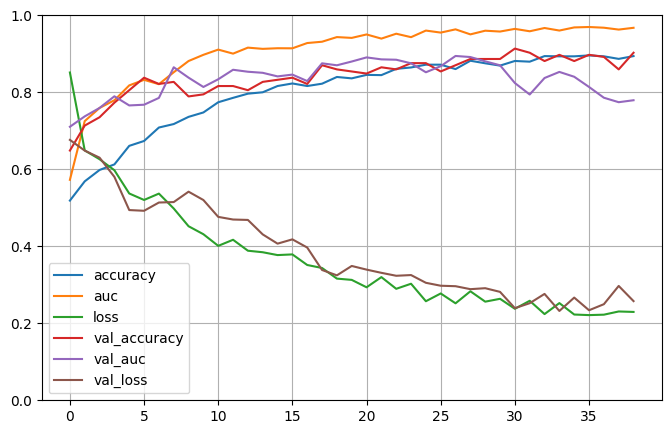

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9245 - auc: 0.9473 - loss: 0.2336
Fold 1 Accuracy (local test): 0.9133
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

--- Fold 2 ---
Epoch 1/200


/home/maro/Documents/uniAndes/deepLearning/vDeepL/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4895 - auc: 0.4915 - loss: 0.8630 - val_accuracy: 0.6054 - val_auc: 0.5168 - val_loss: 0.6927
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5255 - auc: 0.6641 - loss: 0.7181 - val_accuracy: 0.6811 - val_auc: 0.6327 - val_loss: 0.6382
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5337 - auc: 0.7164 - loss: 0.6056 - val_accuracy: 0.7405 - val_auc: 0.7277 - val_loss: 0.5727
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5948 - auc: 0.8587 - loss: 0.5142 - val_accuracy: 0.8108 - val_auc: 0.8347 - val_loss: 0.4887
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6203 - auc: 0.7391 - loss: 0.5677 - val_accuracy: 0.7784 - val_auc: 0.8324 - val_loss: 0.4946
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6580 - auc: 0.8811 - loss: 0.4494 - val_accuracy: 0.8162 - val_auc: 0.8650 - val_loss: 0.4886
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accur

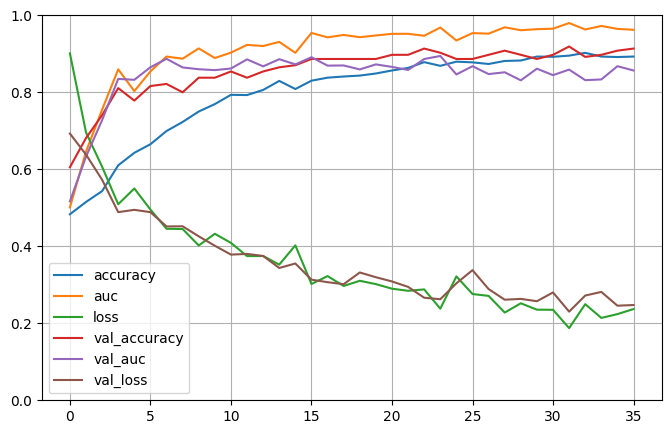

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9330 - auc: 0.9490 - loss: 0.2152 
Fold 2 Accuracy (local test): 0.9209
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

--- Fold 3 ---
Epoch 1/200


/home/maro/Documents/uniAndes/deepLearning/vDeepL/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4764 - auc: 0.5290 - loss: 0.9500 - val_accuracy: 0.5135 - val_auc: 0.6662 - val_loss: 0.7031
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5110 - auc: 0.6306 - loss: 0.7068 - val_accuracy: 0.5784 - val_auc: 0.8054 - val_loss: 0.6701
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5383 - auc: 0.6760 - loss: 0.7019 - val_accuracy: 0.6757 - val_auc: 0.8520 - val_loss: 0.6248
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5889 - auc: 0.8045 - loss: 0.5724 - val_accuracy: 0.6486 - val_auc: 0.8636 - val_loss: 0.6330
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5866 - auc: 0.7970 - loss: 0.5413 - val_accuracy: 0.6865 - val_auc: 0.8687 - val_loss: 0.6194
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6305 - auc: 0.8345 - loss: 0.5531 - val_accuracy: 0.6432 - val_auc: 0.8478 - val_loss: 0.6596
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accur

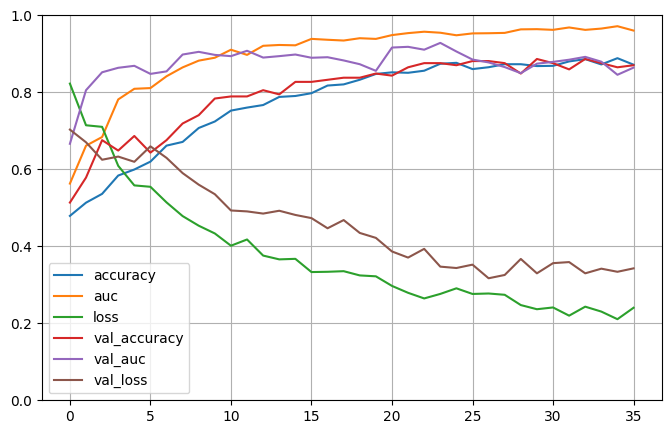

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9244 - auc: 0.9272 - loss: 0.2591
Fold 3 Accuracy (local test): 0.8915
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

--- Fold 4 ---
Epoch 1/200


/home/maro/Documents/uniAndes/deepLearning/vDeepL/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4662 - auc: 0.4745 - loss: 1.0790 - val_accuracy: 0.2162 - val_auc: 0.7607 - val_loss: 0.8073
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4886 - auc: 0.6071 - loss: 0.8012 - val_accuracy: 0.2811 - val_auc: 0.9474 - val_loss: 0.8353
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5065 - auc: 0.6429 - loss: 0.7734 - val_accuracy: 0.4216 - val_auc: 0.9590 - val_loss: 0.7817
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5864 - auc: 0.7384 - loss: 0.6360 - val_accuracy: 0.5568 - val_auc: 0.9665 - val_loss: 0.6832
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6182 - auc: 0.7831 - loss: 0.5374 - val_accuracy: 0.7081 - val_auc: 0.9544 - val_loss: 0.5946
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6568 - auc: 0.7848 - loss: 0.5584 - val_accuracy: 0.7135 - val_auc: 0.9697 - val_loss: 0.5822
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

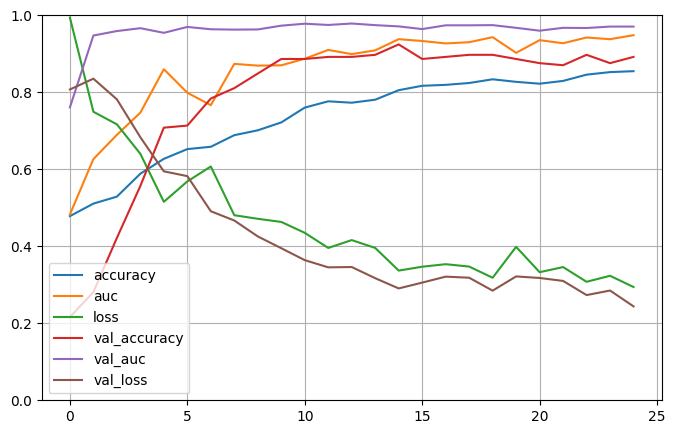

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8760 - auc: 0.9707 - loss: 0.3843
Fold 4 Accuracy (local test): 0.9481
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

--- Fold 5 ---
Epoch 1/200


/home/maro/Documents/uniAndes/deepLearning/vDeepL/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5015 - auc: 0.4842 - loss: 0.9379 - val_accuracy: 0.7459 - val_auc: 0.7803 - val_loss: 0.6484
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5377 - auc: 0.6874 - loss: 0.6903 - val_accuracy: 0.8378 - val_auc: 0.8738 - val_loss: 0.5689
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5801 - auc: 0.7808 - loss: 0.5950 - val_accuracy: 0.8595 - val_auc: 0.9274 - val_loss: 0.4975
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5969 - auc: 0.7981 - loss: 0.5586 - val_accuracy: 0.8865 - val_auc: 0.9390 - val_loss: 0.4314
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6274 - auc: 0.7680 - loss: 0.7090 - val_accuracy: 0.8811 - val_auc: 0.9106 - val_loss: 0.4064
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6888 - auc: 0.8469 - loss: 0.4823 - val_accuracy: 0.8757 - val_auc: 0.9022 - val_loss: 0.3972
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accur

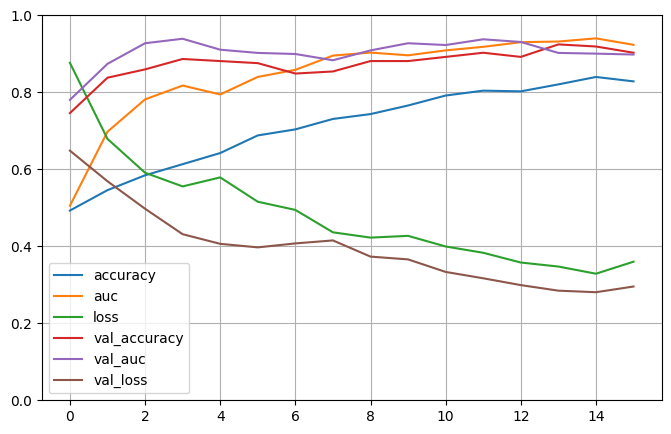

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9208 - auc: 0.9170 - loss: 0.4261
Fold 5 Accuracy (local test): 0.8836
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

--- Fold 6 ---
Epoch 1/200


/home/maro/Documents/uniAndes/deepLearning/vDeepL/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4883 - auc: 0.5142 - loss: 0.9205 - val_accuracy: 0.3424 - val_auc: 0.7832 - val_loss: 0.7428
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5471 - auc: 0.7822 - loss: 0.6335 - val_accuracy: 0.5924 - val_auc: 0.8709 - val_loss: 0.6809
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5459 - auc: 0.6149 - loss: 0.7435 - val_accuracy: 0.6304 - val_auc: 0.8603 - val_loss: 0.6552
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5873 - auc: 0.7356 - loss: 0.6123 - val_accuracy: 0.7935 - val_auc: 0.9168 - val_loss: 0.5594
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6356 - auc: 0.8209 - loss: 0.5577 - val_accuracy: 0.8261 - val_auc: 0.9307 - val_loss: 0.5129
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6801 - auc: 0.8110 - loss: 0.5787 - val_accuracy: 0.8533 - val_auc: 0.9385 - val_loss: 0.4541
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

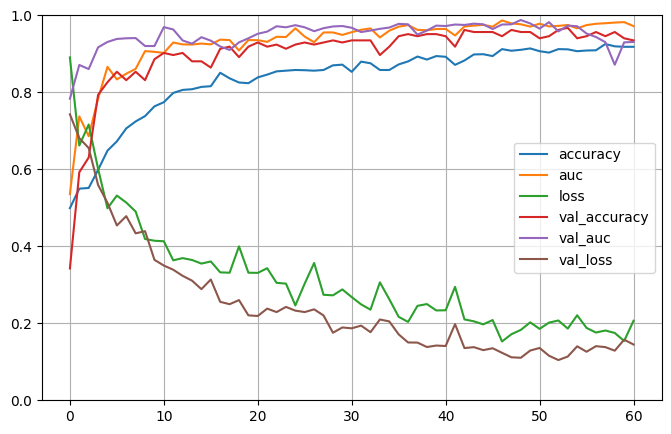

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9424 - auc: 0.9364 - loss: 0.1734
Fold 6 Accuracy (local test): 0.9028
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

--- Fold 7 ---
Epoch 1/200


/home/maro/Documents/uniAndes/deepLearning/vDeepL/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5167 - auc: 0.5436 - loss: 0.7187 - val_accuracy: 0.5163 - val_auc: 0.7190 - val_loss: 0.6936
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5200 - auc: 0.6252 - loss: 0.7136 - val_accuracy: 0.7663 - val_auc: 0.7179 - val_loss: 0.5864
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5694 - auc: 0.7353 - loss: 0.5773 - val_accuracy: 0.7391 - val_auc: 0.7391 - val_loss: 0.5643
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5839 - auc: 0.7114 - loss: 0.6836 - val_accuracy: 0.7554 - val_auc: 0.7771 - val_loss: 0.5377
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6198 - auc: 0.8476 - loss: 0.5258 - val_accuracy: 0.7826 - val_auc: 0.7670 - val_loss: 0.4814
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6485 - auc: 0.8338 - loss: 0.5312 - val_accuracy: 0.8098 - val_auc: 0.7480 - val_loss: 0.4664
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

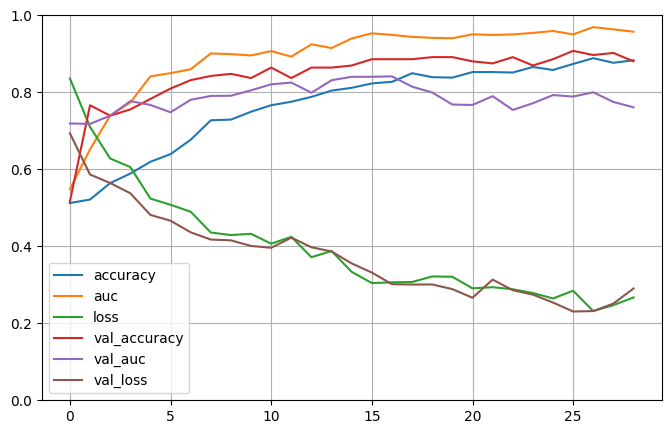

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9196 - auc: 0.9429 - loss: 0.2686
Fold 7 Accuracy (local test): 0.9142
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

--- Fold 8 ---
Epoch 1/200


/home/maro/Documents/uniAndes/deepLearning/vDeepL/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5030 - auc: 0.4100 - loss: 1.0533 - val_accuracy: 0.8478 - val_auc: 0.7838 - val_loss: 0.5922
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5299 - auc: 0.6303 - loss: 0.7373 - val_accuracy: 0.7717 - val_auc: 0.7939 - val_loss: 0.5590
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5755 - auc: 0.7964 - loss: 0.5819 - val_accuracy: 0.8043 - val_auc: 0.7665 - val_loss: 0.5321
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - auc: 0.8003 - loss: 0.6240 - val_accuracy: 0.8913 - val_auc: 0.7352 - val_loss: 0.5061
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6548 - auc: 0.8198 - loss: 0.5404 - val_accuracy: 0.8152 - val_auc: 0.7402 - val_loss: 0.5023
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6775 - auc: 0.8117 - loss: 0.4767 - val_accuracy: 0.8424 - val_auc: 0.7480 - val_loss: 0.5105
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accur

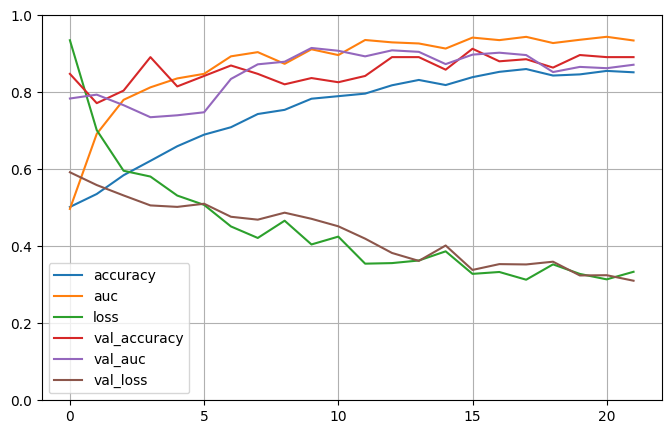

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8943 - auc: 0.9541 - loss: 0.3548 
Fold 8 Accuracy (local test): 0.9338
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

--- Fold 9 ---
Epoch 1/200


/home/maro/Documents/uniAndes/deepLearning/vDeepL/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5190 - auc: 0.5985 - loss: 0.8631 - val_accuracy: 0.7500 - val_auc: 0.6872 - val_loss: 0.6217
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5094 - auc: 0.6240 - loss: 0.8343 - val_accuracy: 0.7663 - val_auc: 0.6916 - val_loss: 0.5727
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5729 - auc: 0.7771 - loss: 0.6253 - val_accuracy: 0.8533 - val_auc: 0.6972 - val_loss: 0.4783
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5847 - auc: 0.6449 - loss: 0.6770 - val_accuracy: 0.8913 - val_auc: 0.6927 - val_loss: 0.4167
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6418 - auc: 0.7951 - loss: 0.5921 - val_accuracy: 0.8804 - val_auc: 0.7028 - val_loss: 0.4011
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6596 - auc: 0.8720 - loss: 0.4968 - val_accuracy: 0.8750 - val_auc: 0.6816 - val_loss: 0.4095
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accur

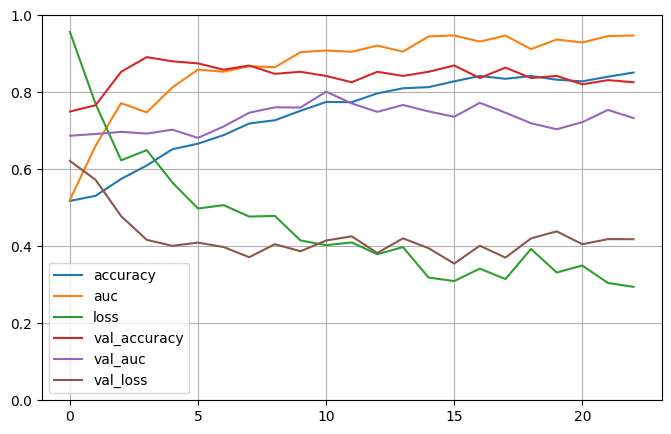

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8909 - auc: 0.9640 - loss: 0.2989
Fold 9 Accuracy (local test): 0.9384
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

--- Fold 10 ---
Epoch 1/200


/home/maro/Documents/uniAndes/deepLearning/vDeepL/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5165 - auc: 0.5534 - loss: 0.8375 - val_accuracy: 0.7717 - val_auc: 0.8038 - val_loss: 0.6453
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5630 - auc: 0.6709 - loss: 0.6504 - val_accuracy: 0.8641 - val_auc: 0.8390 - val_loss: 0.5311
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5494 - auc: 0.7398 - loss: 0.5997 - val_accuracy: 0.9022 - val_auc: 0.8759 - val_loss: 0.4436
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6159 - auc: 0.8691 - loss: 0.5280 - val_accuracy: 0.9130 - val_auc: 0.8525 - val_loss: 0.4101
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6832 - auc: 0.8253 - loss: 0.4949 - val_accuracy: 0.9185 - val_auc: 0.8427 - val_loss: 0.3515
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7040 - auc: 0.8757 - loss: 0.4391 - val_accuracy: 0.8967 - val_auc: 0.8825 - val_loss: 0.3063
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accur

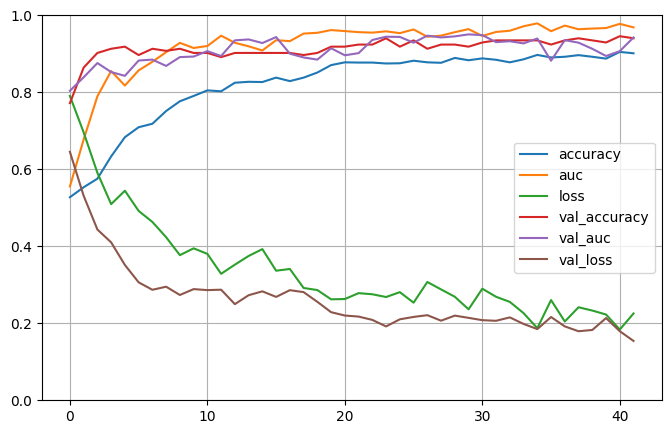

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9398 - auc: 0.9278 - loss: 0.2049
Fold 10 Accuracy (local test): 0.8890
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [15]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_array, y_train_array)):
    print(f"\n--- Fold {fold + 1} ---")

    X_fold_train, X_fold_val = X_train_array[train_idx], X_train_array[val_idx]
    y_fold_train, y_fold_val = y_train_array[train_idx], y_train_array[val_idx]

    model = entrenamiento_modelo(X_fold_train.shape[1])

    history = model.fit(
        X_fold_train, y_fold_train,
        validation_data=(X_fold_val, y_fold_val),
        epochs=200,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1)

    # graficar el entrenamiento del modelo
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show()

    test_loss, test_auc, test_acc = model.evaluate(X_test_array, y_test_array)
    print(f"Fold {fold+1} Accuracy (local test): {test_acc:.4f}")
    fold_auc_scores.append(test_acc)

    # Predicción para el conjunto de prueba real (test_data.csv)
    fold_submission_preds = model.predict(X_real_test_array).flatten()
    predicciones_totales.append(fold_submission_preds)
    submission_preds += fold_submission_preds / n_splits

In [16]:
y_predict = [x for x in submission_preds]

In [20]:
resultado = pd.DataFrame({'ID': df_test['ID'].values, 'Bankruptcy': y_predict})
resultado.head()

,ID,Bankruptcy
0,5,0.355649
1,14,0.396247
2,16,0.091037
3,26,0.303608
4,28,0.082232


In [18]:
resultado.to_csv('submission.csv', index=False)

## Modelo 4

### Selección de variables

In [44]:
var_eliminar = ["ID"]

In [45]:
x_filtro4 = x.drop(columns=var_eliminar)
print(f"Columnas de entrada {x_filtro4.shape[1]}")

Columnas de entrada 63


### Estandarizacion de dataset y conjuntos entrenamiento y prueba

In [46]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scale',  RobustScaler(),       x_filtro4.columns),
        ('power',  PowerTransformer(),   x_filtro4.columns)   # suaviza colas
    ],
    remainder='drop'
)

In [47]:
X_proces = preprocessor.fit_transform(x_filtro4)

C:\Users\danie\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\danie\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_proces, y, stratify=y, test_size=0.1, random_state=42)

In [49]:
# Transformar a formato NumPy
X_train_array = np.array(X_train, dtype=np.float32)
X_test_array = np.array(X_test, dtype=np.float32)

y_train_array = np.array(y_train, dtype=np.float32)
y_test_array = np.array(y_test, dtype=np.float32)

In [50]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train_array)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

### Entrenamiento del modelo

In [51]:
def entrenamiento_modelo_2(dim_entrada, lr=5e-4, l2=1e-4, dropout=0.3):

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(128, activation='selu', kernel_regularizer=regularizers.l2(l2), input_shape=(dim_entrada,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(64, activation='selu', kernel_regularizer=regularizers.l2(l2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(32, activation='selu', kernel_regularizer=regularizers.l2(l2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(dropout/2))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    opt  = Adam(learning_rate=lr)
    #loss = BinaryFocalCrossentropy(alpha=0.75, gamma=2.0)
    loss = 'binary_crossentropy'
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy', AUC(name='auc')])

    return model

In [52]:
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=15,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

In [53]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [54]:
df_test = pd.read_csv('test_data.csv')
X_real_test = df_test.drop(columns=var_eliminar)

In [55]:
X_real_test_scaled = preprocessor.transform(X_real_test)
X_real_test_array = np.array(X_real_test_scaled, dtype=np.float32)

In [56]:
submission_preds  = np.zeros(len(X_real_test_array))
predicciones_totales = []
fold_auc_scores = []

In [57]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)


--- Fold 1 ---


C:\Users\danie\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5497 - auc: 0.5183 - loss: 0.8947 - val_accuracy: 0.8865 - val_auc: 0.5601 - val_loss: 1402.9779
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5454 - auc: 0.5479 - loss: 0.8828 - val_accuracy: 0.9027 - val_auc: 0.5312 - val_loss: 541.3561
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5708 - auc: 0.5962 - loss: 0.7747 - val_accuracy: 0.8108 - val_auc: 0.4781 - val_loss: 0.6106
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5709 - auc: 0.5105 - loss: 0.7963 - val_accuracy: 0.9027 - val_auc: 0.5372 - val_loss: 0.5910
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5890 - auc: 0.5314 - loss: 0.9199 - val_accuracy: 0.9297 - val_auc: 0.5121 - val_loss: 0.6008
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5833 - auc: 0.6103 - loss: 0.8086 - val_accuracy: 0.9405 - val_auc: 0.5768 - val_loss: 0.6056
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━

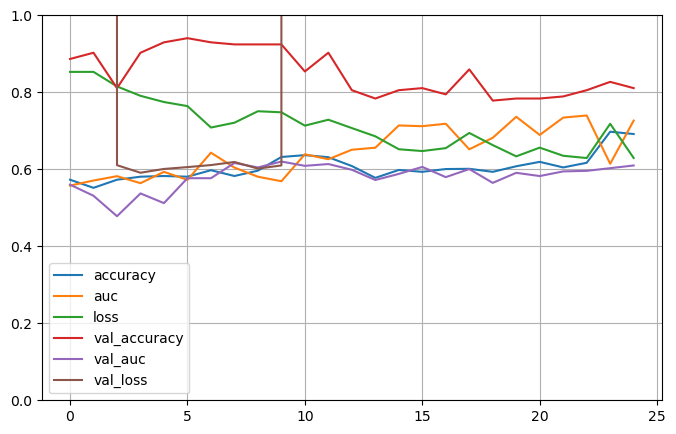

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8556 - auc: 0.5150 - loss: 0.6841 
Fold 1 AUC (local test): 0.8585
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

--- Fold 2 ---


C:\Users\danie\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.4743 - auc: 0.5646 - loss: 0.7472 - val_accuracy: 0.8270 - val_auc: 0.3329 - val_loss: 36.1764
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4876 - auc: 0.4790 - loss: 0.8361 - val_accuracy: 0.8216 - val_auc: 0.3329 - val_loss: 33.1253
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5294 - auc: 0.7066 - loss: 0.6984 - val_accuracy: 0.8216 - val_auc: 0.3352 - val_loss: 32.5013
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5657 - auc: 0.5779 - loss: 0.8426 - val_accuracy: 0.8162 - val_auc: 0.3073 - val_loss: 32.4096
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5993 - auc: 0.6261 - loss: 0.7459 - val_accuracy: 0.8270 - val_auc: 0.4013 - val_loss: 35.3681
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6038 - auc: 0.6402 - loss: 0.7022 - val_accuracy: 0.8270 - val_auc: 0.3142 - val_loss: 37.9570
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━

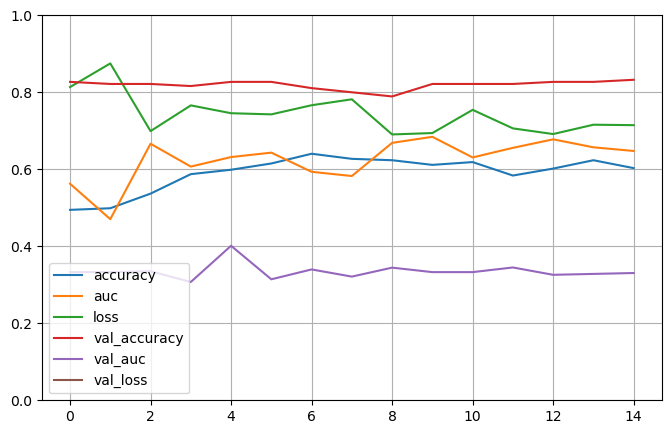

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8925 - auc: 0.6020 - loss: 0.6863 
Fold 2 AUC (local test): 0.8927
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

--- Fold 3 ---


C:\Users\danie\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.4573 - auc: 0.3763 - loss: 1.6006 - val_accuracy: 0.9135 - val_auc: 0.4139 - val_loss: 0.7774
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5202 - auc: 0.4911 - loss: 0.9740 - val_accuracy: 0.8973 - val_auc: 0.5000 - val_loss: 0.7192
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5470 - auc: 0.5659 - loss: 0.8179 - val_accuracy: 0.8865 - val_auc: 0.5140 - val_loss: 0.7530
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5180 - auc: 0.5633 - loss: 0.8896 - val_accuracy: 0.9027 - val_auc: 0.5033 - val_loss: 0.6839
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5447 - auc: 0.6324 - loss: 0.7762 - val_accuracy: 0.8919 - val_auc: 0.5033 - val_loss: 0.6913
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5533 - auc: 0.5873 - loss: 0.9225 - val_accuracy: 0.8865 - val_auc: 0.5033 - val_loss: 0.6703
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 

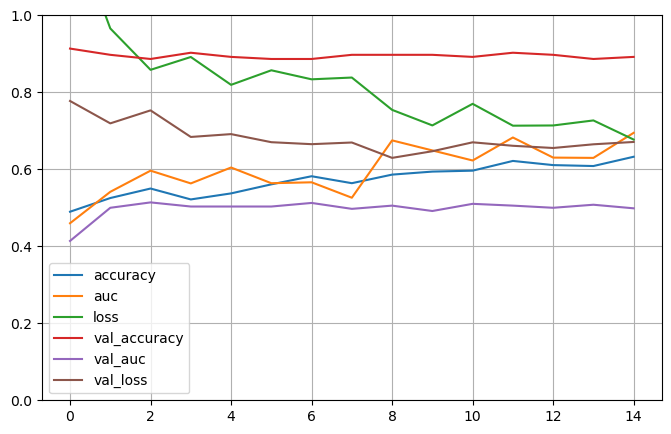

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8993 - auc: 0.5236 - loss: 0.8539 
Fold 3 AUC (local test): 0.8976
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

--- Fold 4 ---


C:\Users\danie\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.4599 - auc: 0.4406 - loss: 0.9205 - val_accuracy: 0.9027 - val_auc: 0.6010 - val_loss: 0.7236
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5430 - auc: 0.5909 - loss: 0.7574 - val_accuracy: 0.9135 - val_auc: 0.6173 - val_loss: 0.7079
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5317 - auc: 0.5119 - loss: 0.9609 - val_accuracy: 0.9135 - val_auc: 0.6080 - val_loss: 0.7052
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5644 - auc: 0.4995 - loss: 0.8036 - val_accuracy: 0.8973 - val_auc: 0.6024 - val_loss: 0.7305
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5488 - auc: 0.6055 - loss: 0.6839 - val_accuracy: 0.9081 - val_auc: 0.6001 - val_loss: 0.7318
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5794 - auc: 0.5484 - loss: 0.7792 - val_accuracy: 0.8919 - val_auc: 0.5968 - val_loss: 0.7414
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 

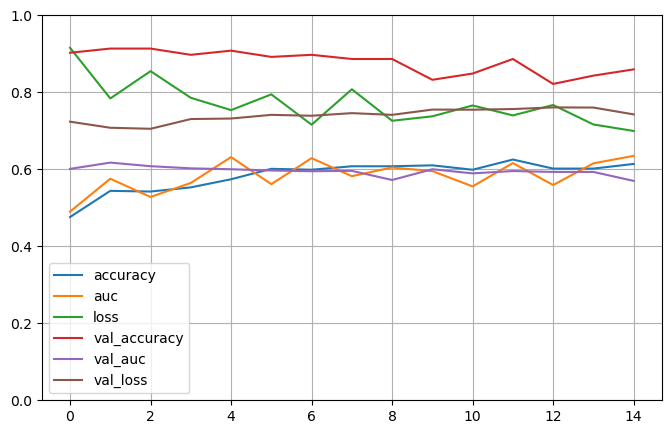

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8786 - auc: 0.5833 - loss: 0.7557 
Fold 4 AUC (local test): 0.8780
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

--- Fold 5 ---


C:\Users\danie\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5261 - auc: 0.5133 - loss: 0.8161 - val_accuracy: 0.8865 - val_auc: 0.5014 - val_loss: 0.8936
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5603 - auc: 0.5456 - loss: 0.9386 - val_accuracy: 0.8919 - val_auc: 0.5703 - val_loss: 0.8077
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5784 - auc: 0.6258 - loss: 0.7641 - val_accuracy: 0.8919 - val_auc: 0.5130 - val_loss: 0.7762
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5937 - auc: 0.5565 - loss: 0.7094 - val_accuracy: 0.8919 - val_auc: 0.5689 - val_loss: 0.7794
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5790 - auc: 0.5644 - loss: 0.7489 - val_accuracy: 0.8757 - val_auc: 0.5051 - val_loss: 0.8000
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5804 - auc: 0.5957 - loss: 0.6772 - val_accuracy: 0.8757 - val_auc: 0.5307 - val_loss: 0.7658
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 

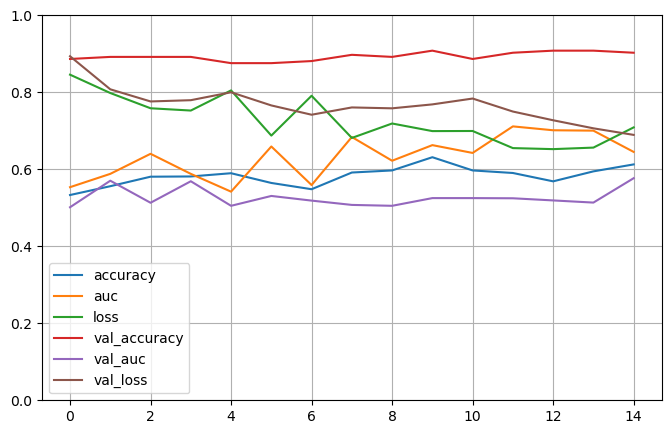

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8790 - auc: 0.5898 - loss: 0.8935 
Fold 5 AUC (local test): 0.8780
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

--- Fold 6 ---


C:\Users\danie\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5372 - auc: 0.5352 - loss: 0.8187 - val_accuracy: 0.9076 - val_auc: 0.6313 - val_loss: 0.6717
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5706 - auc: 0.6138 - loss: 0.8678 - val_accuracy: 0.8804 - val_auc: 0.5978 - val_loss: 0.6944
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5526 - auc: 0.5325 - loss: 0.6914 - val_accuracy: 0.8587 - val_auc: 0.6302 - val_loss: 0.7180
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5502 - auc: 0.6386 - loss: 0.7578 - val_accuracy: 0.8315 - val_auc: 0.6067 - val_loss: 0.7238
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5619 - auc: 0.5780 - loss: 0.8440 - val_accuracy: 0.8804 - val_auc: 0.6291 - val_loss: 0.7137
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5655 - auc: 0.5535 - loss: 0.7656 - val_accuracy: 0.8641 - val_auc: 0.6201 - val_loss: 0.7274
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 

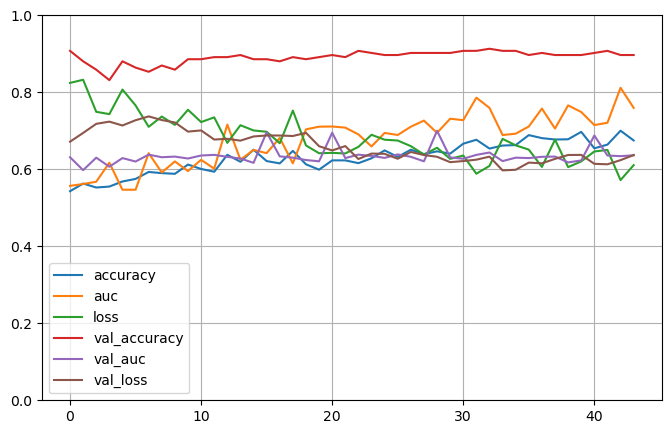

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8710 - auc: 0.5806 - loss: 0.6407 
Fold 6 AUC (local test): 0.8683
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

--- Fold 7 ---


C:\Users\danie\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5124 - auc: 0.4632 - loss: 1.0084 - val_accuracy: 0.8641 - val_auc: 0.5827 - val_loss: 0.7305
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5042 - auc: 0.4807 - loss: 0.9837 - val_accuracy: 0.8641 - val_auc: 0.5274 - val_loss: 0.7485
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5626 - auc: 0.4925 - loss: 1.0048 - val_accuracy: 0.8478 - val_auc: 0.5240 - val_loss: 0.7631
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5520 - auc: 0.5894 - loss: 0.8228 - val_accuracy: 0.8370 - val_auc: 0.5296 - val_loss: 0.7798
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5519 - auc: 0.6318 - loss: 0.6817 - val_accuracy: 0.0272 - val_auc: 0.5302 - val_loss: 0.7699
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5461 - auc: 0.5550 - loss: 0.7977 - val_accuracy: 0.8478 - val_auc: 0.5318 - val_loss: 0.7470
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 

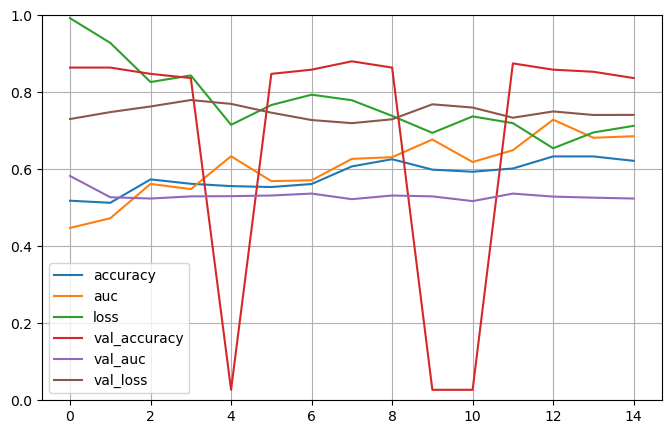

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8636 - auc: 0.6692 - loss: 0.7976 
Fold 7 AUC (local test): 0.8537
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

--- Fold 8 ---


C:\Users\danie\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.4973 - auc: 0.5163 - loss: 0.9112 - val_accuracy: 0.8804 - val_auc: 0.5453 - val_loss: 0.8903
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5173 - auc: 0.5085 - loss: 0.9118 - val_accuracy: 0.8859 - val_auc: 0.5536 - val_loss: 0.8421
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4993 - auc: 0.5100 - loss: 0.8184 - val_accuracy: 0.8750 - val_auc: 0.5430 - val_loss: 0.7620
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5624 - auc: 0.5735 - loss: 0.8221 - val_accuracy: 0.8804 - val_auc: 0.5363 - val_loss: 0.7212
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5391 - auc: 0.5278 - loss: 0.7179 - val_accuracy: 0.8859 - val_auc: 0.5564 - val_loss: 0.6905
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5415 - auc: 0.5802 - loss: 0.7387 - val_accuracy: 0.8913 - val_auc: 0.5894 - val_loss: 0.7182
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 

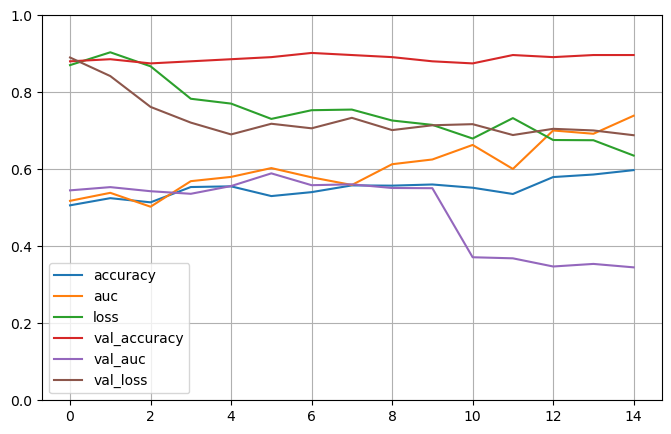

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8759 - auc: 0.5916 - loss: 0.9588 
Fold 8 AUC (local test): 0.8732
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

--- Fold 9 ---


C:\Users\danie\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5098 - auc: 0.4507 - loss: 1.0210 - val_accuracy: 0.9511 - val_auc: 0.6028 - val_loss: 0.6600
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5214 - auc: 0.4774 - loss: 0.8716 - val_accuracy: 0.9239 - val_auc: 0.8458 - val_loss: 0.6609
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5632 - auc: 0.6150 - loss: 0.7193 - val_accuracy: 0.9457 - val_auc: 0.5989 - val_loss: 0.6964
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5081 - auc: 0.5817 - loss: 0.7662 - val_accuracy: 0.9457 - val_auc: 0.8341 - val_loss: 0.6299
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5626 - auc: 0.5323 - loss: 0.7652 - val_accuracy: 0.9348 - val_auc: 0.8486 - val_loss: 0.6360
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6215 - auc: 0.5826 - loss: 0.7540 - val_accuracy: 0.9293 - val_auc: 0.8413 - val_loss: 0.6592
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 

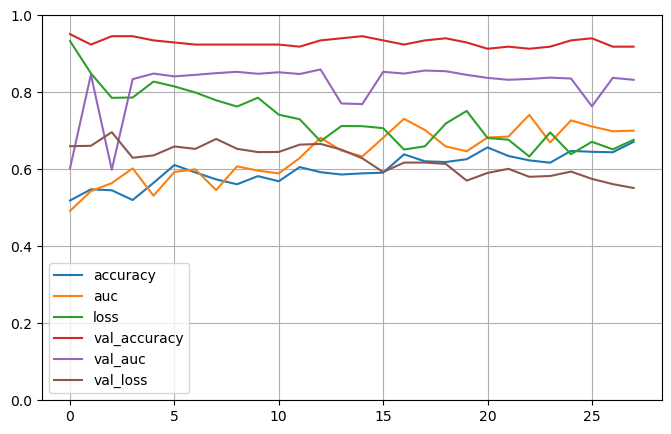

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9011 - auc: 0.6081 - loss: 0.7020 
Fold 9 AUC (local test): 0.9024
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

--- Fold 10 ---


C:\Users\danie\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5687 - auc: 0.5318 - loss: 0.8118 - val_accuracy: 0.9130 - val_auc: 0.6924 - val_loss: 0.6858
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5639 - auc: 0.4503 - loss: 0.9250 - val_accuracy: 0.9130 - val_auc: 0.6849 - val_loss: 0.6717
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5475 - auc: 0.5270 - loss: 0.7491 - val_accuracy: 0.9185 - val_auc: 0.6821 - val_loss: 0.6640
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5245 - auc: 0.6019 - loss: 0.6951 - val_accuracy: 0.9185 - val_auc: 0.6250 - val_loss: 0.6502
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5876 - auc: 0.6110 - loss: 0.7708 - val_accuracy: 0.9130 - val_auc: 0.6774 - val_loss: 0.6446
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5246 - auc: 0.4995 - loss: 0.7338 - val_accuracy: 0.9239 - val_auc: 0.6798 - val_loss: 0.6550
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 

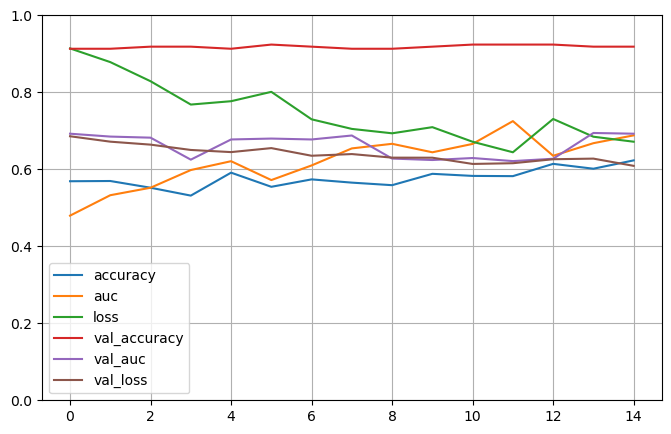

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8952 - auc: 0.5858 - loss: 0.9028 
Fold 10 AUC (local test): 0.8976
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [58]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_array, y_train_array)):
    print(f"\n--- Fold {fold + 1} ---")

    X_fold_train, X_fold_val = X_train_array[train_idx], X_train_array[val_idx]
    y_fold_train, y_fold_val = y_train_array[train_idx], y_train_array[val_idx]

    #X_tr_bal, y_tr_bal = smote.fit_resample(X_fold_train, y_fold_train)

    model = entrenamiento_modelo_2(dim_entrada=X_fold_train.shape[1])

    history = model.fit(
        X_fold_train, y_fold_train,
        validation_data=(X_fold_val, y_fold_val),
        epochs=200,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1)

    # graficar el entrenamiento del modelo
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show()

    test_loss, test_auc, test_acc = model.evaluate(X_test_array, y_test_array)
    print(f"Fold {fold+1} AUC (local test): {test_auc:.4f}")
    fold_auc_scores.append(test_auc)

    # Predicción para el conjunto de prueba real (test_data.csv)
    fold_submission_preds = model.predict(X_real_test_array).flatten()
    predicciones_totales.append(fold_submission_preds)
    submission_preds += fold_submission_preds / n_splits

In [26]:
y_predict = [x for x in submission_preds]

In [19]:
resultado = pd.DataFrame({'ID': df_test['ID'].values, 'Bankruptcy': y_predict})
resultado.head()

,ID,Bankruptcy
0,5,0.355649
1,14,0.396247
2,16,0.091037
3,26,0.303608
4,28,0.082232


In [28]:
resultado.to_csv('submission.csv', index=False)

# Prediccion nuevos datos

In [ ]:
# Cargar Datos de prueba
df_test = pd.read_csv('test_data.csv')

# vista previa
df_test.head()

In [ ]:
def preprocesamiento1(df, lista_eliminar):

    df_filtro = df.drop(columns=lista_eliminar)
    
    df_scaled = scaler.fit_transform(df_filtro)
    df_array = np.array(df_scaled, dtype=np.float32)

    return df_array


In [ ]:
df_test.shape

In [ ]:
df_predict = preprocesamiento1(df_test, var_eliminar)

In [ ]:
df_predict.shape

In [ ]:
y_predict = model.predict(df_predict)

In [ ]:
y_predict

In [ ]:
y_predict = [round(x[0], 4) for x in y_predict]

In [ ]:
resultado = pd.DataFrame({'ID': df_test['ID'].values, 'Bankruptcy': y_predict})
resultado.head()

In [ ]:
resultado.groupby("Bankruptcy").size()

In [ ]:
# Crear csv con las predicciones

resultado.to_csv('submission.csv', index=False)